In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from dateutil.parser import parse

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.data import Dataset

import tensorflow as tf

import statsmodels.api as sm

from hyperas import optim
from hyperopt import Trials, tpe

import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics, VAR, SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA



from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import STATUS_OK

In [16]:
df = pd.read_csv("differenced_data_365only.csv", parse_dates=[0])
df.set_index("date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26775 entries, 1947-06-18 to 2020-10-08
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              26775 non-null  float64
 1   dewp              26775 non-null  float64
 2   slp               26775 non-null  float64
 3   visib             26775 non-null  float64
 4   wdsp              26775 non-null  float64
 5   max               26775 non-null  float64
 6   min               26775 non-null  float64
 7   fog               26775 non-null  float64
 8   rain_drizzle      26775 non-null  float64
 9   snow_ice_pellets  26775 non-null  float64
 10  hail              26775 non-null  float64
 11  thunder           26775 non-null  float64
dtypes: float64(12)
memory usage: 2.7 MB


In [45]:
normal_df_full = pd.read_csv("model_data.csv", parse_dates=[1])
normal_df_full.drop(["Unnamed: 0", "year sin", "year cos"], axis=1, inplace=True)
normal_df_full.set_index("Date", inplace=True)
normal_df = normal_df_full.loc[normal_df_full.index.date > dt.date(2019, 10, 1)]

normal_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2019-10-02 to 2020-10-08
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              373 non-null    float64
 1   dewp              373 non-null    float64
 2   slp               373 non-null    float64
 3   visib             373 non-null    float64
 4   wdsp              373 non-null    float64
 5   max               373 non-null    float64
 6   min               373 non-null    float64
 7   fog               373 non-null    float64
 8   rain_drizzle      373 non-null    float64
 9   snow_ice_pellets  373 non-null    float64
 10  hail              373 non-null    float64
 11  thunder           373 non-null    float64
dtypes: float64(12)
memory usage: 37.9 KB


In [18]:
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]

In [19]:
scaler = StandardScaler()
scaler.fit(train_df)

StandardScaler()

In [20]:
scaler_means = scaler.mean_
scaler_var = scaler.var_
scaler_data = {
    "scale_means": scaler_means,
    "scale_vars": scaler_var
}
pd.DataFrame(scaler_data).to_csv("scaler_data.csv")

In [21]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [22]:
input_width = 6
label_width = 6
shift = 1
label_columns = None

In [23]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

In [24]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns is not None:
        labels = tf.stack(
            [labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [25]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [26]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)

In [27]:
def make_models(lstm_size, dense_size, dense_layer_num, activation, optimizer):

    model = Sequential()
    model.add(LSTM(lstm_size, return_sequences=True))
    for i in range(dense_layer_num):
        model.add(Dense(units=dense_size, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(12))

    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(model_train, epochs=10, validation_data=model_val, callbacks=[e_stop])

    return {"loss": np.amin(history.history["val_loss"]), "status": STATUS_OK, "model":model}

In [28]:
histories = []
lstm_sizes = [16]
dense_sizes = [50]
dense_layers = [0]
activations = ["relu"]
optimizers = ["adam"]
for lstm_size in lstm_sizes:
    for dense_size in dense_sizes:
        for dense_layer_num in dense_layers:
            for activation in activations:
                for optimizer in optimizers:
                    histories.append(make_models(lstm_size=lstm_size,
                                            dense_size=dense_size,
                                            dense_layer_num=dense_layer_num,
                                            activation=activation,
                                            optimizer=optimizer))

Epoch 1/10
586/586 [==============================] - 5s 8ms/step - loss: 0.8284 - mean_absolute_error: 0.5633 - val_loss: 0.5068 - val_mean_absolute_error: 0.4470
Epoch 2/10
586/586 [==============================] - 4s 7ms/step - loss: 0.7189 - mean_absolute_error: 0.5180 - val_loss: 0.4798 - val_mean_absolute_error: 0.4352
Epoch 3/10
586/586 [==============================] - 4s 7ms/step - loss: 0.7022 - mean_absolute_error: 0.5095 - val_loss: 0.4722 - val_mean_absolute_error: 0.4318
Epoch 4/10
586/586 [==============================] - 4s 7ms/step - loss: 0.6975 - mean_absolute_error: 0.5068 - val_loss: 0.4705 - val_mean_absolute_error: 0.4318
Epoch 5/10
586/586 [==============================] - 4s 6ms/step - loss: 0.6950 - mean_absolute_error: 0.5060 - val_loss: 0.4687 - val_mean_absolute_error: 0.4308
Epoch 6/10
586/586 [==============================] - 4s 6ms/step - loss: 0.6931 - mean_absolute_error: 0.5055 - val_loss: 0.4681 - val_mean_absolute_error: 0.4309
Epoch 7/10
586/5

In [29]:
histories[0]["model"].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 16)             1856      
_________________________________________________________________
dropout (Dropout)            (None, 6, 16)             0         
_________________________________________________________________
dense (Dense)                (None, 6, 12)             204       
Total params: 2,060
Trainable params: 2,060
Non-trainable params: 0
_________________________________________________________________


In [30]:
for hist in histories:
    print(hist["loss"])

0.46594688296318054


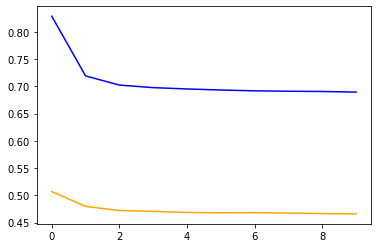

In [31]:
test_model = histories[0]["model"]
plt.plot(test_model.history.history["loss"], color="blue")
plt.plot(test_model.history.history["val_loss"], color="orange")
plt.show()

In [32]:
save_model = histories[0]["model"]
save_model.save_weights("weightsDifference")

In [33]:
predictions = histories[0]["model"].predict(model_test)

In [34]:
output_df = pd.DataFrame(predictions[:,5,:], columns=df.columns, index=test_df[6:].index)
output_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder
date,,,,,,,,,,,,
2013-06-16,0.003719,0.058755,0.291371,-0.200827,-0.087740,-0.013918,0.020950,0.135717,0.039584,0.005294,-0.012378,0.001260
2013-06-17,-0.754022,-0.776646,-0.086234,0.286097,-0.464785,-0.521711,-0.850399,-0.376629,-0.250574,0.029231,0.010670,-0.109682
2013-06-18,-0.636043,-0.269208,0.303885,0.383367,-0.185300,-0.456963,-0.726931,0.463755,-0.200356,-0.379488,-0.073597,-0.544553
2013-06-19,-0.336562,-0.267033,-0.100605,0.092132,-0.179635,-0.315204,-0.294387,-0.046328,0.074836,0.005468,-0.001680,0.052674
2013-06-20,0.186811,-0.034721,-0.417013,0.184990,-0.040884,0.342827,0.035180,-0.076563,-0.122224,-0.054669,0.014666,-0.013710
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-04,-0.868368,-0.961287,1.516246,0.357246,-0.455139,-0.651990,-0.957591,-0.396923,-0.442570,0.072842,-0.058466,-0.348963
2020-10-05,0.784625,0.531583,-1.476466,0.124031,0.692682,0.925206,0.564212,-0.060359,-0.152213,-0.052226,0.078756,-0.036589
2020-10-06,-0.148098,-0.248047,-0.116382,0.230738,0.266337,-0.112453,-0.157736,-0.196128,-0.028292,-0.014543,0.005490,-0.042220


In [35]:
residuals_df = output_df - test_df[6:]
residuals_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder
date,,,,,,,,,,,,
2013-06-16,-3.696281,-0.301245,1.451371,-0.220827,0.232260,-6.313918,0.440950,0.335717,0.839584,0.005294,-0.012378,0.601260
2013-06-17,-4.314022,-5.336646,1.173766,0.126097,-2.004785,-4.741711,-3.210399,-0.376629,-0.250574,0.029231,0.010670,-0.109682
2013-06-18,-4.876043,-3.189208,-2.476115,0.423367,-1.865300,-6.416963,-5.126931,0.463755,-0.200356,-0.379488,-0.073597,-0.744553
2013-06-19,-4.356562,0.112967,-2.100605,-0.167868,1.920365,-10.935204,-0.754387,0.153672,0.074836,0.005468,-0.001680,0.052674
2013-06-20,-4.233189,-1.034721,-2.797013,-0.115010,0.659116,-6.437173,-1.764820,-0.076563,-0.122224,-0.054669,0.014666,-0.413710
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-04,8.871632,10.598713,-3.243754,0.997246,-0.475139,5.508010,13.222409,-0.596923,-0.442570,0.072842,-0.058466,-0.348963
2020-10-05,8.764625,10.491583,-7.176466,-0.795969,0.312682,7.885206,8.624212,0.139641,-0.152213,-0.052226,0.078756,-0.036589
2020-10-06,6.171902,11.171953,-1.816382,1.130738,2.886337,0.847547,11.002264,-0.196128,-0.028292,-0.014543,0.005490,-0.042220


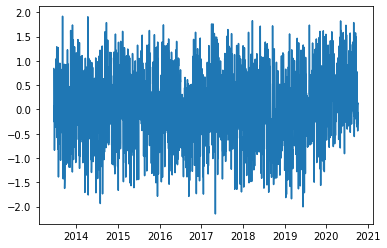

In [36]:
plt.plot(residuals_df["rain_drizzle"])

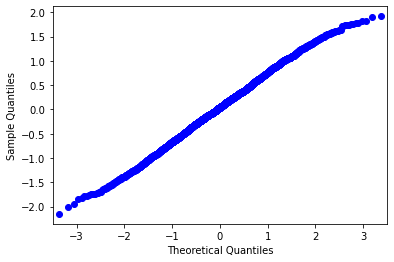

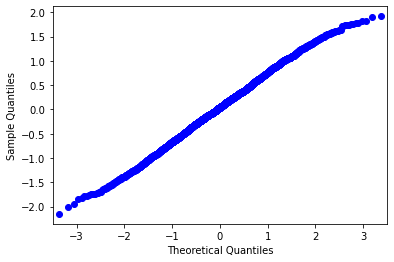

In [37]:
sm.graphics.qqplot(residuals_df["rain_drizzle"])

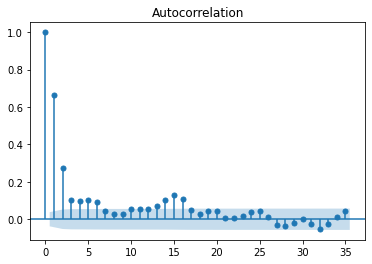

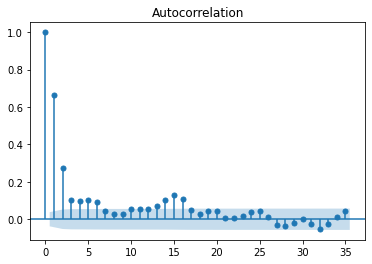

In [38]:
import statsmodels
statsmodels.graphics.tsaplots.plot_acf(residuals_df["temp"])

In [43]:
inv_station = []
inv_index = []
for row in output_df.itertuples():
    date = row[0] - dt.timedelta(days=365)
    if (date.date() > dt.date(2019, 10, 1)):
        last_year = normal_df.loc[normal_df.index.date == date.date()]
        predict_row = last_year + row[1:]
        predict_row = predict_row[0:].values.reshape(-1, 12)[0]
        inv_station.append(predict_row)
        inv_index.append(date + dt.timedelta(days=365))



In [35]:
inv_station_full = []
inv_index_full = []
for row in output_df.itertuples():
    date = row[0] - dt.timedelta(days=365)
    last_year = normal_df_full.loc[normal_df_full.index.date == date.date()]
    predict_row = last_year + row[1:]
    predict_row = predict_row[0:].values.reshape(-1, 12)[0]
    inv_station_full.append(predict_row)
    inv_index_full.append(date + dt.timedelta(days=365))

In [286]:
# mminv_station_full = []
# mminv_index_full = []
# for row in minmax_df.itertuples():
#     date = parse(row[0]) - dt.timedelta(days=365)
#     last_year = normal_df_full.loc[normal_df_full.index.date == date.date()]
#     predict_row = last_year + row[1:]
#     predict_row = predict_row[0:].values.reshape(-1, 12)[0]
#     mminv_station_full.append(predict_row)
#     mminv_index_full.append(date + dt.timedelta(days=365))

In [46]:
normal_df.to_csv("last_year_lookup.csv")

In [40]:
predictions_full = pd.DataFrame(data=inv_station_full, columns=output_df.columns, index=inv_index_full)


In [41]:
predictions_df = pd.DataFrame(data=inv_station, columns = output_df.columns, index=inv_index)


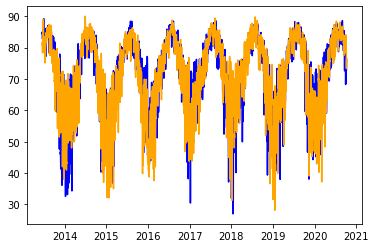

In [42]:
plt.plot(normal_df_full["temp"].tail(2672), color="blue")
plt.plot(predictions_full["temp"], color="orange")

In [245]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [269]:
def testPlot(var, tail):

    plt.plot(normal_df_full[var].tail(tail), color="blue")
    plt.plot(predictions_full[var].tail(tail), color="orange")
    plt.show()

In [268]:
def testPlot_mm(var, tail):

    plt.plot(normal_df_full[var].tail(tail), color="blue")
    plt.plot(minmax_df[var].tail(tail), color="orange")
    plt.show()

In [283]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2672 entries, 2013-06-16 to 2020-10-08
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              2672 non-null   float32
 1   dewp              2672 non-null   float32
 2   slp               2672 non-null   float32
 3   visib             2672 non-null   float32
 4   wdsp              2672 non-null   float32
 5   max               2672 non-null   float32
 6   min               2672 non-null   float32
 7   fog               2672 non-null   float32
 8   rain_drizzle      2672 non-null   float32
 9   snow_ice_pellets  2672 non-null   float32
 10  hail              2672 non-null   float32
 11  thunder           2672 non-null   float32
dtypes: float32(12)
memory usage: 226.1+ KB


In [280]:
from sklearn.preprocessing import MinMaxScaler
minMax = MinMaxScaler()
minMax.fit(output_df)
rain_drizzle = minMax.transform(output_df)
minmax_df = pd.DataFrame(rain_drizzle, columns=df.columns, index=inv_index_full)

minmax_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2672 entries, 2013-06-16 to 2020-10-08
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              2672 non-null   float32
 1   dewp              2672 non-null   float32
 2   slp               2672 non-null   float32
 3   visib             2672 non-null   float32
 4   wdsp              2672 non-null   float32
 5   max               2672 non-null   float32
 6   min               2672 non-null   float32
 7   fog               2672 non-null   float32
 8   rain_drizzle      2672 non-null   float32
 9   snow_ice_pellets  2672 non-null   float32
 10  hail              2672 non-null   float32
 11  thunder           2672 non-null   float32
dtypes: float32(12)
memory usage: 146.1 KB


count    2672.000000
mean        0.486270
std         0.165322
min         0.000000
25%         0.367505
50%         0.478797
75%         0.598768
max         1.000000
Name: rain_drizzle, dtype: float64

In [277]:
testPlot_mm("rain_drizzle", 365)